In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.signal import butter, sosfiltfilt, find_peaks
from utils import *
import os
from enum import Enum

%matplotlib inline
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14
np.set_printoptions(threshold=sys.maxsize,
                    suppress=True)

import torch
import torch.nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader

torch.manual_seed(114514)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(torch.__config__.show())
print(f'PyTorch is running on {device}')

PyTorch built with:
  - C++ Version: 201703
  - MSVC 192930151
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.3.2 (Git Hash 2dc95a2ad0841e29db8b22fbccaf3e5da7992b01)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86;-gencode;arch=compute_90,code=sm_90
  - CuDNN 8.8.1  (built against CUDA 12.0)
  - Magma 2.5.4
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=12.1, CUDNN_VERSION=8.8.1, CXX_COMPILER=C:/actions-runner/_work/pytorch/pytorch/builder/windows/tmp_bin/sccache-cl.exe, CXX_FLAGS=/DWIN32 /D_WINDOWS /GR /EHsc /Zc:__cplusplus /bigob

In [2]:
print(torch.__version__)

2.2.1+cu121


In [3]:
directory = '../dataset/yihan_20231130'
filenames = [filename for filename in os.listdir(directory) if filename.endswith('.csv')]
labels = [filename.split('.')[0] for filename in filenames]
labels

['breathing',
 'deep_breath',
 'dry_cough',
 'running',
 'swallow',
 'throat_clearing']

In [4]:
class Label(Enum):
    DEEP_BREATH = 0
    SWALLOWING = 1
    DRY_COUGH = 2
    THROAT_CLEARING = 3
    JUMPING_JACK = 4
    PUSH_UP = 5

In [5]:
class LHMDualDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, idx):
        photovoltage_data = self.features[idx, :4, :].float().transpose(0, 1)
        euler_angle_data = self.features[idx, 4:, :].float().transpose(0, 1)
        return photovoltage_data, euler_angle_data, self.labels[idx]

running.csv
torch.Size([10, 1])
torch.Size([10, 7, 3000])


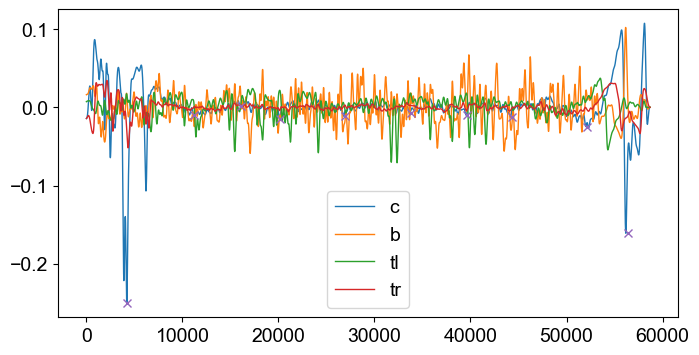

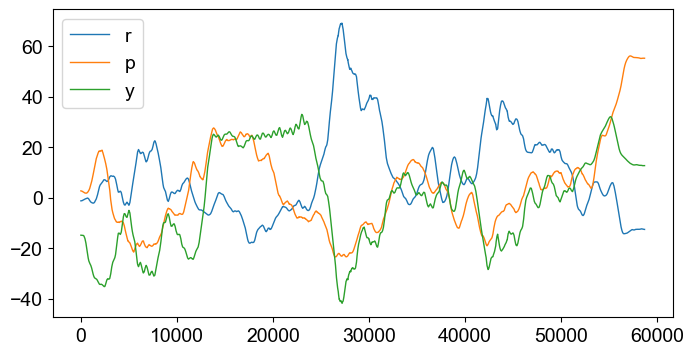

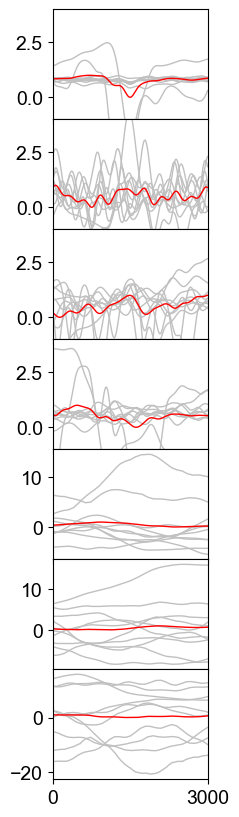

In [9]:
# swallowing
# Load
filename = filenames[3]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'yihan_20231130', filename), delimiter=',', header=None)

# Trim
data_raw = data_raw.iloc[150:900]

timestamps, c, b, tl, tr, r, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
p = detrend(p, method='butter', fc=2)
r, p, y = despike(r, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, r, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(3, [0.1, 3], 'bandpass', output='sos', fs=1000) # for pvs
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)
sos = butter(2, [3, 7], 'bandstop', output='sos', fs=1000) # for angles
data[:, 4:] = sosfiltfilt(sos, data[:, 4:], axis=0)


# Find peaks
peaks, _ = find_peaks(-data[:, 0], distance=4000)
plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, :4])
plt.plot(peaks, data[peaks, 0], 'x')
plt.legend(['c', 'b', 'tl', 'tr'])

plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, 4:])
plt.legend(['r', 'p', 'y'])

# Construct slices
window_width = 3000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))
slices_100 = []
for idx in range(expanded_peaks.shape[0]):
    slices_100.append(data[expanded_peaks[idx, :]])
slices_100 = np.array(slices_100)

# Create mask to filter outliers
mask = np.all(np.array([filter_windows(channel) for channel in np.transpose(slices_100,
                                                                            (1, 0, 2))]),
              axis=0)
slices_100 = slices_100[mask.astype(bool), :, :]
slices_100 = torch.tensor(np.transpose(slices_100, (0, 2, 1)))
labels_100 = torch.broadcast_to(torch.tensor(Label.SWALLOWING.value), (slices_100.shape[0], 1))
print(labels_100.shape)
print(slices_100.shape)

# Normalize after constructing slices using the average window as reference
slices_mean = torch.mean(slices_100, axis=0) # [n_ch, n_points]
slices_normalized = torch.zeros_like(slices_100)
slices_min = torch.zeros(slices_mean.shape[0])
amp_factors = torch.zeros(slices_mean.shape[0])
for ch in range(slices_mean.shape[0]):
    ch_max = torch.max(slices_mean[ch, :])
    ch_min = torch.min(slices_mean[ch, :])
    slices_min[ch] = ch_min
    amp_factors[ch] = 1 / (ch_max - ch_min)
for ch in range(slices_100.shape[1]):
    slices_normalized[:, ch, :] = (slices_100[:, ch, :] - slices_min[ch]) * amp_factors[ch]
slices_100 = slices_normalized

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(2, 10), sharex=True)
fig.subplots_adjust(hspace=0)
for ch, ax in enumerate(axes):
    for idx in range(slices_100.shape[0]):
        ax.plot(slices_100[idx, ch, :], 'silver')
    ax.plot((slices_mean[ch, :] - slices_min[ch]) * amp_factors[ch], 'r')
    ax.set_xlim(0, window_width)
    ax.set_xticks([0, window_width])
    if ch < 4:
        ax.set_ylim(-1, 4)
plt.show()

deep_breath.csv
torch.Size([31, 1])
torch.Size([31, 7, 3000])


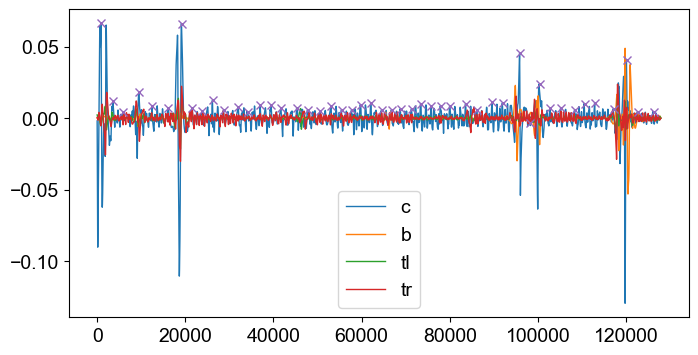

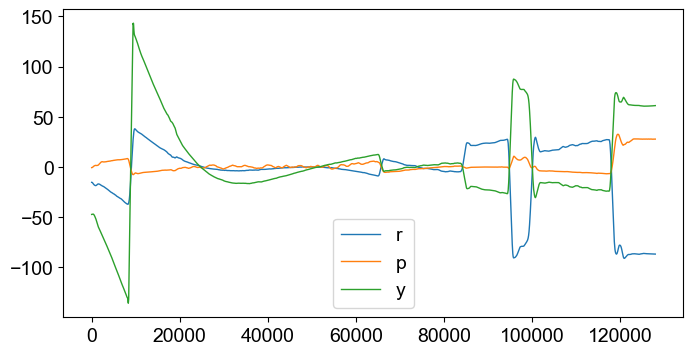

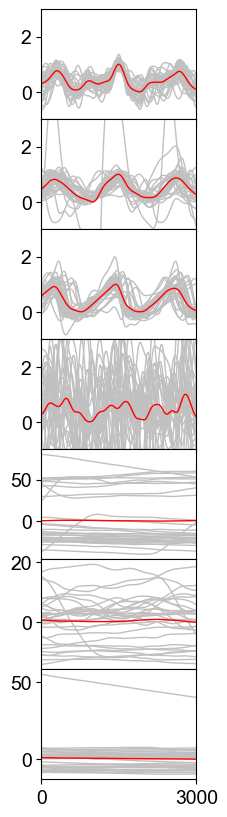

In [8]:
# dry cough
# Load
filename = filenames[1]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'yihan_20231130', filename), delimiter=',', header=None)

# Trim
data_raw = data_raw.iloc[25:]

timestamps, c, b, tl, tr, r, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
r = detrend(r, method='butter', fc=2)
y = detrend(y, method='butter', fc=2)
p = detrend(p, method='butter', fc=2)
r, p, y = despike(r, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, r, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(3, [0.5, 5], 'bandpass', output='sos', fs=1000) # for pvs
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)
sos = butter(2, [3, 7], 'bandstop', output='sos', fs=1000) # for angles
data[:, 4:] = sosfiltfilt(sos, data[:, 4:], axis=0)

# Find peaks
peaks, _ = find_peaks(data[:, 0], distance=2000) # NOTE: Choose from seven channels to get the best result
plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, :4])
plt.plot(peaks, data[peaks, 0], 'x')
plt.legend(['c', 'b', 'tl', 'tr'])

plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, 4:])
plt.legend(['r', 'p', 'y'])

# Construct slices_0
window_width = 3000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))
slices_101 = []
for idx in range(expanded_peaks.shape[0]):
    slices_101.append(data[expanded_peaks[idx, :]])
slices_101 = np.array(slices_101)

# Create mask to filter outliers
mask = np.all(np.array([filter_windows(channel) for channel in np.transpose(slices_101,
                                                                            (1, 0, 2))]),
              axis=0)
slices_101 = slices_101[mask.astype(bool), :, :]
slices_101 = torch.tensor(np.transpose(slices_101, (0, 2, 1)))
labels_101 = torch.broadcast_to(torch.tensor(Label.DRY_COUGH.value), (slices_101.shape[0], 1))
print(labels_101.shape)
print(slices_101.shape)

# Normalize after constructing slices using the average window as reference
slices_mean = torch.mean(slices_101, axis=0) # [n_ch, n_points]
slices_normalized = torch.zeros_like(slices_101)
slices_min = torch.zeros(slices_mean.shape[0])
amp_factors = torch.zeros(slices_mean.shape[0])
for ch in range(slices_mean.shape[0]):
    ch_max = torch.max(slices_mean[ch, :])
    ch_min = torch.min(slices_mean[ch, :])
    slices_min[ch] = ch_min
    amp_factors[ch] = 1 / (ch_max - ch_min)
for ch in range(slices_101.shape[1]):
    slices_normalized[:, ch, :] = (slices_101[:, ch, :] - slices_min[ch]) * amp_factors[ch]
slices_101 = slices_normalized

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(2, 10), sharex=True)
fig.subplots_adjust(hspace=0)
for ch, ax in enumerate(axes):
    for idx in range(slices_101.shape[0]):
        ax.plot(slices_101[idx, ch, :], 'silver')
    ax.plot((slices_mean[ch, :] - slices_min[ch]) * amp_factors[ch], 'r')
    ax.set_xlim(0, window_width)
    ax.set_xticks([0, window_width])
    if ch < 4:
        ax.set_ylim(-1, 3)
plt.show()

swallow.csv
torch.Size([14, 1])
torch.Size([14, 7, 3000])


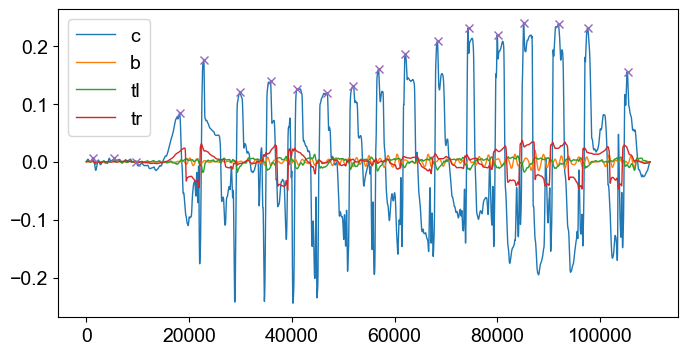

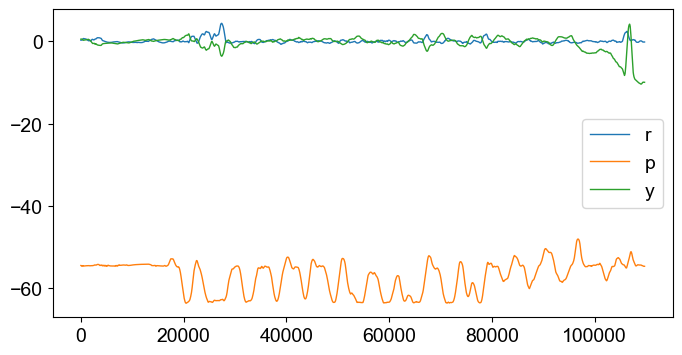

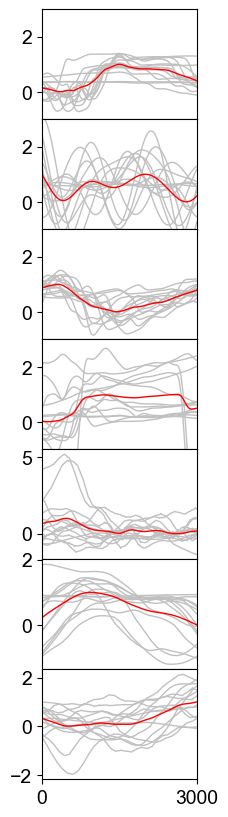

In [11]:
# throat clearing
# Load
filename = filenames[4]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'yihan_20231130', filename), delimiter=',', header=None)
timestamps, c, b, tl, tr, ch, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
y = detrend(y, method='butter', fc=2)
ch, p, y = despike(ch, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, ch, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(3, [0.1, 5], 'bandpass', output='sos', fs=1000) # for pvs
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)
sos = butter(3, [0.5, 1], 'bandpass', output='sos', fs=1000)
data[:, 1] = sosfiltfilt(sos, data[:, 1], axis=0)

sos = butter(2, [3, 7], 'bandstop', output='sos', fs=1000) # for angles
data[:, 4:] = sosfiltfilt(sos, data[:, 4:], axis=0)

# Find peaks
peaks, _ = find_peaks(data[:, 0], distance=4000)
plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, :4])
plt.plot(peaks, data[peaks, 0], 'x')
plt.legend(['c', 'b', 'tl', 'tr'])

plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, 4:])
plt.legend(['r', 'p', 'y'])


# Construct slices_5
window_width = 3000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))

slices_102 = []
for idx in range(expanded_peaks.shape[0]):
    slices_102.append(data[expanded_peaks[idx, :]])
slices_102 = np.array(slices_102)
mask = np.all(np.array([filter_windows(channel) for channel in np.transpose(slices_102,
                                                                            (1, 0, 2))]),
              axis=0)
slices_102 = slices_102[mask.astype(bool), :, :]
slices_102 = torch.tensor(np.transpose(slices_102, (0, 2, 1)))
labels_102 = torch.broadcast_to(torch.tensor(Label.THROAT_CLEARING.value), (slices_102.shape[0], 1))
print(labels_102.shape)
print(slices_102.shape)

# Normalize after constructing slices using the average window as reference
slices_mean = torch.mean(slices_102, axis=0) # [n_ch, n_points]
slices_normalized = torch.zeros_like(slices_102)
slices_min = torch.zeros(slices_mean.shape[0])
amp_factors = torch.zeros(slices_mean.shape[0])
for ch in range(slices_mean.shape[0]):
    ch_max = torch.max(slices_mean[ch, :])
    ch_min = torch.min(slices_mean[ch, :])
    slices_min[ch] = ch_min
    amp_factors[ch] = 1 / (ch_max - ch_min)
for ch in range(slices_102.shape[1]):
    slices_normalized[:, ch, :] = (slices_102[:, ch, :] - slices_min[ch]) * amp_factors[ch]
slices_102 = slices_normalized

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(2, 10), sharex=True)
fig.subplots_adjust(hspace=0)
for ch, ax in enumerate(axes):
    for idx in range(slices_102.shape[0]):
        ax.plot(slices_102[idx, ch, :], 'silver')
    ax.plot((slices_mean[ch, :] - slices_min[ch]) * amp_factors[ch], 'r')
    ax.set_xlim(0, window_width)
    ax.set_xticks([0, window_width])
    if ch < 4:
        ax.set_ylim(-1, 3)
plt.show()

dry_cough.csv
torch.Size([5, 1])
torch.Size([5, 7, 3000])


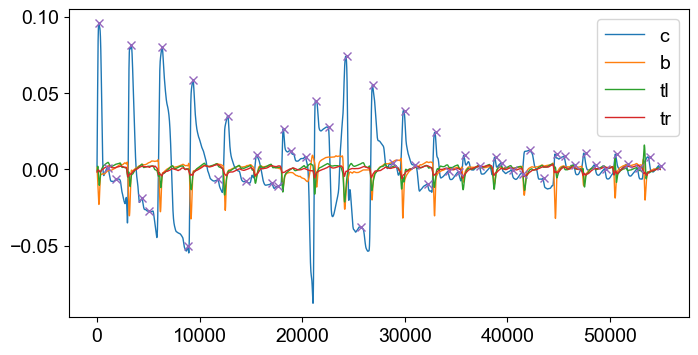

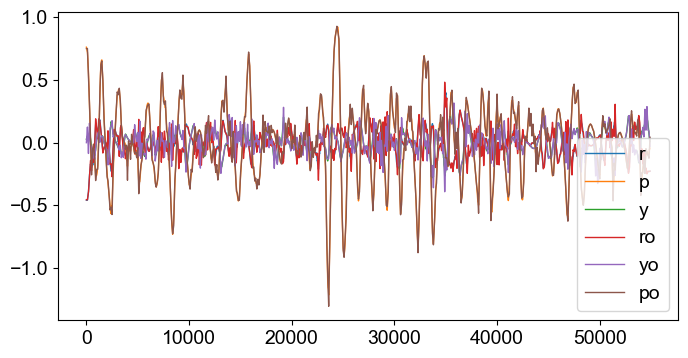

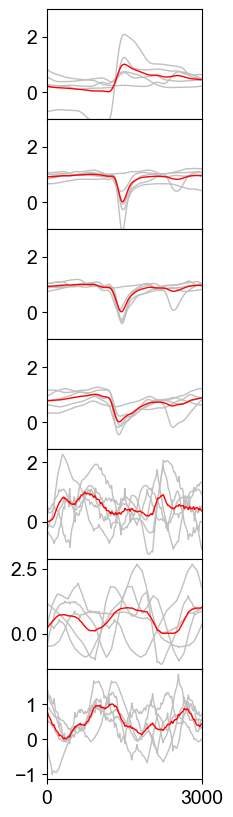

In [15]:
# running
# Load
filename = filenames[2]
print(filename)
data_raw = pd.read_csv(os.path.join('..', 'dataset', 'yihan_20231130', filename), delimiter=',', header=None)
data_raw = data_raw.iloc[250:800]
timestamps, c, b, tl, tr, r, p, y = (data_raw[i].to_numpy() for i in range(data_raw.shape[1]))
timestamps -= timestamps[0]

# Preprocess
r = detrend(r, method='butter', fc=50)
y = detrend(y, method='butter', fc=50)
p = detrend(p, method='butter', fc=50)
r, p, y = despike(r, 10, 0.2), despike(p, 10, 0.2), despike(y, 10, 0.2)

# Upsample
data_combined = np.column_stack([c, b, tl, tr, r, p, y])
data = np.zeros((int(np.around((len(timestamps) + 1) * 100 + 1)), 7))
for i in range(data_combined.shape[1]):
    _, data[:, i] = upsample(timestamps, data_combined[:, i], ratio=100)

_, r = upsample(timestamps, r, ratio=100)
_, y = upsample(timestamps, y, ratio=100)
_, p = upsample(timestamps, p, ratio=100)
timestamps, _ = upsample(timestamps, timestamps, ratio=100) # Update timestamps with the upsampled version

# Butterworth
sos = butter(3, [0.1, 5], 'bandpass', output='sos', fs=1000) # for pvs
data[:, :4] = sosfiltfilt(sos, data[:, :4], axis=0)
sos = butter(2, [3, 7], 'bandstop', output='sos', fs=1000) # for angles
data[:, 4:] = sosfiltfilt(sos, data[:, 4:], axis=0)

# Find peaks
peaks, _ = find_peaks(data[:, 0], distance=500)
plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, :4])
plt.plot(peaks, data[peaks, 0], 'x')
plt.legend(['c', 'b', 'tl', 'tr'])

plt.figure(figsize=(8, 4))
plt.plot(timestamps, data[:, 4:], label=['r', 'p', 'y'])
plt.plot(timestamps, r, label='ro')
plt.plot(timestamps, y, label='yo')
plt.plot(timestamps, p, label='po')
plt.legend()

# Construct slices_3
window_width = 3000
expanded_peaks = peak_expand(peaks, window_width, len(timestamps))

slices_103 = []
for idx in range(expanded_peaks.shape[0]):
    slices_103.append(data[expanded_peaks[idx, :]])
slices_103 = np.array(slices_103)
mask = np.all(np.array([filter_windows(channel) for channel in np.transpose(slices_103,
                                                                            (1, 0, 2))]),
              axis=0)
slices_103 = slices_103[mask.astype(bool), :, :]
slices_103 = torch.tensor(np.transpose(slices_103, (0, 2, 1)))
labels_103 = torch.broadcast_to(torch.tensor(Label.JUMPING_JACK.value), (slices_103.shape[0], 1))
print(labels_103.shape)
print(slices_103.shape)

# Normalize after constructing slices using the average window as reference
slices_mean = torch.mean(slices_103, axis=0) # [n_ch, n_points]
slices_normalized = torch.zeros_like(slices_103)
slices_min = torch.zeros(slices_mean.shape[0])
amp_factors = torch.zeros(slices_mean.shape[0])
for ch in range(slices_mean.shape[0]):
    ch_max = torch.max(slices_mean[ch, :])
    ch_min = torch.min(slices_mean[ch, :])
    slices_min[ch] = ch_min
    amp_factors[ch] = 1 / (ch_max - ch_min)
for ch in range(slices_103.shape[1]):
    slices_normalized[:, ch, :] = (slices_103[:, ch, :] - slices_min[ch]) * amp_factors[ch]
slices_103 = slices_normalized

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(2, 10), sharex=True)
fig.subplots_adjust(hspace=0)
for ch, ax in enumerate(axes):
    for idx in range(slices_103.shape[0]):
        ax.plot(slices_103[idx, ch, :], 'silver')
    ax.plot((slices_mean[ch, :] - slices_min[ch]) * amp_factors[ch], 'r')
    ax.set_xlim(0, window_width)
    ax.set_xticks([0, window_width])
    if ch < 4:
        ax.set_ylim(-1, 3)
plt.show()

In [13]:
all_slices = torch.cat((slices_101, slices_100, slices_102, slices_103), dim=0)
all_labels = torch.cat((labels_101, labels_100, labels_102, labels_103), dim=0)
print(all_slices.shape)
print(all_labels.shape)

torch.Size([73, 7, 3000])
torch.Size([73, 1])


In [44]:
indices = torch.randperm(all_slices.shape[0])[:30]
part_slices = all_slices[indices, ...]
part_labels = all_labels[indices, ...]

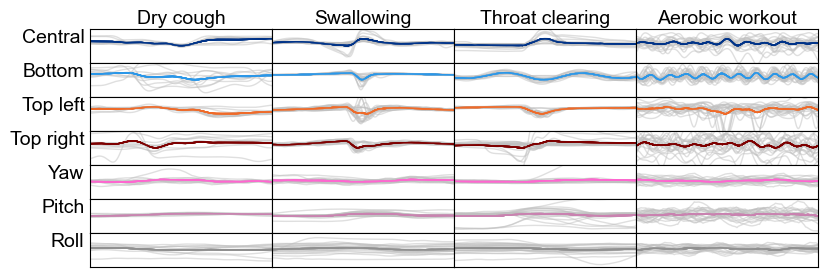

In [84]:
sensors = ['Central',
           'Bottom',
           'Top left',
           'Top right',
           'Yaw',
           'Pitch',
           'Roll']

labels = ['Dry cough',
          'Swallowing',
          'Throat clearing',
          'Aerobic workout']

pv_color = ['#003388', '#2a97e9', '#f06a28', '#7e0000']
or_color = ['#ff66d0', '#ca82b0', '#909090']
colors = pv_color + or_color

fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(8.5, 3))

# Number of classes
n_channels = all_slices.shape[1]
n_classes = 4

class_codes = [Label.SWALLOWING.value,
               Label.DRY_COUGH.value,
               Label.THROAT_CLEARING.value,
               Label.JUMPING_JACK.value]

# Iterate over each channel
for channel in range(n_channels):
    for idx, class_code in enumerate(class_codes):
        ax = axes[channel, idx]
        class_samples = all_slices[all_labels.squeeze() == class_code]
        mean_data = class_samples.mean(dim=0)[channel]
        for sample in class_samples:
            ax.plot(sample[channel], alpha=0.5, color='silver')
            ax.plot(mean_data, color=colors[channel])

        if channel < 4:
            ax.set_ylim(-2.5, 2.5)
            ax.set_yticks([])
        else:
            ax.set_ylim(-7.5, 7.5)
            ax.set_yticks([])

        if idx != 0:
            ax.set_yticks([])
        else:
            ax.set_ylabel(sensors[channel], rotation='horizontal', ha='right')

        if channel == 0:
            ax.set_xlabel(labels[idx])
            ax.xaxis.set_label_position('top') 

        ax.set_xlim(0, 3000)
        ax.set_xticks([])
        
plt.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

# plt.savefig('../results/fig4/adap_all.png', bbox_inches='tight', dpi=600)
plt.show()

In [16]:
dual_ds = LHMDualDataset(all_slices, all_labels)
torch.save(dual_ds, '../dataset/preprocessed/yihan_dual.pt')

In [45]:
part_dual_ds = LHMDualDataset(part_slices, part_labels)
torch.save(part_dual_ds, '../dataset/preprocessed/yihan_part_dual.pt')

In [8]:
input_dim1 = 4 # For nirs data
input_dim2 = 3 # For Euler angle data
hidden_dim = 140
layer_dim = 1
output_dim = 6 # Number of classes
dropout_prob = 0

batch_size = 32

ds = torch.load('../dataset/preprocessed/yihan_dual.pt')
test_ratio = 0.3
test_size = int(test_ratio * len(ds))
train_size = len(ds) - test_size

train_ds, test_ds = random_split(ds, [train_size, test_size])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)


In [7]:
class DualGRUModel(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(DualGRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # GRU layers
        self.gru1 = nn.GRU(input_dim1, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        self.gru2 = nn.GRU(input_dim2, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):
        # Initialize hidden states for both GRUs
        h01 = torch.zeros(self.layer_dim, x1.size(0), self.hidden_dim).requires_grad_().to(device)
        h02 = torch.zeros(self.layer_dim, x2.size(0), self.hidden_dim).requires_grad_().to(device)

        out1, _ = self.gru1(x1, h01.detach())
        out2, _ = self.gru2(x2, h02.detach())

        # Concatenate the outputs from both GRUs
        out = torch.cat((out1[:, -1, :], out2[:, -1, :]), 1)

        out = self.fc(out)
        out = self.softmax(out)
        return out

Fine tune model

In [ ]:
# train_losses = []
# train_accuracies = []
# test_losses = []
# test_accuracies = []

# model = DualGRUModel(input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob)
# model.load_state_dict(torch.load('../models/gru_dual_lr0_0001_wd_0_01.pt'))
# model.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=0.01)

# fine_tune_epochs = 400

# for epoch in range(fine_tune_epochs):
#     model.train()
#     total_train_loss = 0.0
#     total_train_correct = 0
#     total_train_samples = 0

#     for photovoltage_data, euler_angle_data, labels in train_loader:
#         photovoltage_data = photovoltage_data.to(device)
#         euler_angle_data = euler_angle_data.to(device)
#         labels = labels.to(device)

#         outputs = model(photovoltage_data, euler_angle_data)
#         loss = criterion(outputs, labels.squeeze())

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_train_loss += loss.item()
#         _, predicted = torch.max(outputs.data, 1)
#         total_train_samples += labels.size(0)
#         total_train_correct += (predicted == labels.squeeze()).sum().item()

#     avg_train_loss = total_train_loss / len(train_loader)
#     train_accuracy = total_train_correct / total_train_samples
#     train_losses.append(avg_train_loss)
#     train_accuracies.append(train_accuracy)

#     model.eval()
#     total_test_loss = 0.0
#     total_test_correct = 0
#     total_test_samples = 0

#     with torch.no_grad():
#         for photovoltage_data, euler_angle_data, labels in test_loader:
#             photovoltage_data = photovoltage_data.to(device)
#             euler_angle_data = euler_angle_data.to(device)
#             labels = labels.to(device)

#             outputs = model(photovoltage_data, euler_angle_data)
#             loss = criterion(outputs, labels.squeeze())

#             total_test_loss += loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             total_test_samples += labels.size(0)
#             total_test_correct += (predicted == labels.squeeze()).sum().item()

#         avg_test_loss = total_test_loss / len(test_loader)
#         test_accuracy = total_test_correct / total_test_samples
#         test_losses.append(avg_test_loss)
#         test_accuracies.append(test_accuracy)

#     # Print training and testing statistics for each epoch
#     if (epoch+1) % 5 == 0:
#         print(f'Epoch [{epoch+1}/{fine_tune_epochs}], '
#               f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
#               f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Domain Adaptation

In [10]:
class AdaptedDualGRUModel(nn.Module):
    def __init__(self, input_dim1, input_dim2, adaptation_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(AdaptedDualGRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # Additional adaptation layers
        self.adaptation_layer11 = nn.Linear(input_dim1, adaptation_dim)
        self.adaptation_layer12 = nn.Linear(input_dim2, adaptation_dim)
        
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()

        self.adaptation_layer21 = nn.Linear(adaptation_dim, input_dim1)
        self.adaptation_layer22 = nn.Linear(adaptation_dim, input_dim2)

        # GRU layers
        self.gru1 = nn.GRU(input_dim1, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        self.gru2 = nn.GRU(input_dim2, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x1, x2):
        # Apply the adaptation layers
        x1 = self.adaptation_layer11(x1)
        x2 = self.adaptation_layer12(x2)

        x1 = self.relu1(x1)
        x2 = self.relu2(x2)

        x1 = self.adaptation_layer21(x1)
        x2 = self.adaptation_layer22(x2)
        
        # Initialize hidden states for both GRUs
        h01 = torch.zeros(self.layer_dim, x1.size(0), self.hidden_dim).requires_grad_().to(device)
        h02 = torch.zeros(self.layer_dim, x2.size(0), self.hidden_dim).requires_grad_().to(device)

        out1, _ = self.gru1(x1, h01.detach())
        out2, _ = self.gru2(x2, h02.detach())

        # Concatenate the outputs from both GRUs
        out = torch.cat((out1[:, -1, :], out2[:, -1, :]), 1)

        out = self.fc(out)
        out = self.softmax(out)
        return out

In [11]:
adaptation_dim = 64
model_adap = AdaptedDualGRUModel(input_dim1, input_dim2, adaptation_dim, hidden_dim, layer_dim, output_dim, dropout_prob)

pretrained_dict = torch.load('../models/gru_dual_lr0_0001_wd_0_01.pt')
adaptation_layer_keys = ['adaptation_layer1.weight', 'adaptation_layer1.bias', 
                         'adaptation_layer2.weight', 'adaptation_layer2.bias']
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k not in adaptation_layer_keys}
model_adap.load_state_dict(pretrained_dict, strict=False)
model_adap.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_adap.parameters(), lr=0.005, weight_decay=0.001)

train_losses_ada = []
train_accuracies_ada = []
test_losses_ada = []
test_accuracies_ada = []

num_epochs = 50

for epoch in range(num_epochs):
    model_adap.train()
    total_train_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0

    for photovoltage_data, euler_angle_data, labels in train_loader:
        photovoltage_data = photovoltage_data.to(device)
        euler_angle_data = euler_angle_data.to(device)
        labels = labels.to(device)

        outputs = model_adap(photovoltage_data, euler_angle_data)
        loss = criterion(outputs, labels.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        total_train_correct += (predicted == labels.squeeze()).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_train_correct / total_train_samples
    train_losses_ada.append(avg_train_loss)
    train_accuracies_ada.append(train_accuracy)

    model_adap.eval()
    total_test_loss = 0.0
    total_test_correct = 0
    total_test_samples = 0

    with torch.no_grad():
        for photovoltage_data, euler_angle_data, labels in test_loader:
            photovoltage_data = photovoltage_data.to(device)
            euler_angle_data = euler_angle_data.to(device)
            labels = labels.to(device)

            outputs = model_adap(photovoltage_data, euler_angle_data)
            loss = criterion(outputs, labels.squeeze())

            total_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test_samples += labels.size(0)
            total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader)
        test_accuracy = total_test_correct / total_test_samples
        test_losses_ada.append(avg_test_loss)
        test_accuracies_ada.append(test_accuracy)

    # Print training and testing statistics for each epoch
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch [5/50], Train Loss: 1.4497, Train Accuracy: 0.3462, Test Loss: 1.4952, Test Accuracy: 0.3810
Epoch [10/50], Train Loss: 1.2999, Train Accuracy: 0.4423, Test Loss: 1.3802, Test Accuracy: 0.3333
Epoch [15/50], Train Loss: 1.1951, Train Accuracy: 0.4808, Test Loss: 1.2458, Test Accuracy: 0.3333
Epoch [20/50], Train Loss: 0.8787, Train Accuracy: 0.5962, Test Loss: 0.9257, Test Accuracy: 0.5238
Epoch [25/50], Train Loss: 0.5536, Train Accuracy: 0.8269, Test Loss: 1.1389, Test Accuracy: 0.6667
Epoch [30/50], Train Loss: 0.4149, Train Accuracy: 0.9038, Test Loss: 1.0380, Test Accuracy: 0.7143
Epoch [35/50], Train Loss: 0.2623, Train Accuracy: 0.9615, Test Loss: 0.5761, Test Accuracy: 0.8095
Epoch [40/50], Train Loss: 0.1262, Train Accuracy: 0.9808, Test Loss: 0.4662, Test Accuracy: 0.8571
Epoch [45/50], Train Loss: 0.1621, Train Accuracy: 0.9423, Test Loss: 1.1605, Test Accuracy: 0.6190
Epoch [50/50], Train Loss: 0.1379, Train Accuracy: 0.9423, Test Loss: 0.5512, Test Accuracy: 0.7143


In [12]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

model = DualGRUModel(input_dim1, input_dim2, hidden_dim, layer_dim, output_dim, dropout_prob)
model.load_state_dict(torch.load('../models/gru_dual_lr0_0001_wd_0_01.pt'))
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)

fine_tune_epochs = 50

for epoch in range(fine_tune_epochs):
    model.train()
    total_train_loss = 0.0
    total_train_correct = 0
    total_train_samples = 0

    for photovoltage_data, euler_angle_data, labels in train_loader:
        photovoltage_data = photovoltage_data.to(device)
        euler_angle_data = euler_angle_data.to(device)
        labels = labels.to(device)

        outputs = model(photovoltage_data, euler_angle_data)
        loss = criterion(outputs, labels.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        total_train_correct += (predicted == labels.squeeze()).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = total_train_correct / total_train_samples
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    total_test_loss = 0.0
    total_test_correct = 0
    total_test_samples = 0

    with torch.no_grad():
        for photovoltage_data, euler_angle_data, labels in test_loader:
            photovoltage_data = photovoltage_data.to(device)
            euler_angle_data = euler_angle_data.to(device)
            labels = labels.to(device)

            outputs = model(photovoltage_data, euler_angle_data)
            loss = criterion(outputs, labels.squeeze())

            total_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test_samples += labels.size(0)
            total_test_correct += (predicted == labels.squeeze()).sum().item()

        avg_test_loss = total_test_loss / len(test_loader)
        test_accuracy = total_test_correct / total_test_samples
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)

    # Print training and testing statistics for each epoch
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{fine_tune_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
              f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Epoch [5/50], Train Loss: 1.4159, Train Accuracy: 0.4038, Test Loss: 1.4696, Test Accuracy: 0.4286
Epoch [10/50], Train Loss: 1.1241, Train Accuracy: 0.5000, Test Loss: 1.3684, Test Accuracy: 0.2857
Epoch [15/50], Train Loss: 1.5152, Train Accuracy: 0.4038, Test Loss: 2.2459, Test Accuracy: 0.1905
Epoch [20/50], Train Loss: 1.1685, Train Accuracy: 0.4423, Test Loss: 1.2467, Test Accuracy: 0.5238
Epoch [25/50], Train Loss: 1.0936, Train Accuracy: 0.5192, Test Loss: 1.4349, Test Accuracy: 0.5238
Epoch [30/50], Train Loss: 0.9518, Train Accuracy: 0.6731, Test Loss: 1.2586, Test Accuracy: 0.5714
Epoch [35/50], Train Loss: 0.6953, Train Accuracy: 0.7308, Test Loss: 0.9584, Test Accuracy: 0.7143
Epoch [40/50], Train Loss: 0.9600, Train Accuracy: 0.6346, Test Loss: 1.5219, Test Accuracy: 0.4762
Epoch [45/50], Train Loss: 1.0033, Train Accuracy: 0.5385, Test Loss: 1.4781, Test Accuracy: 0.6190
Epoch [50/50], Train Loss: 0.5429, Train Accuracy: 0.9038, Test Loss: 1.2577, Test Accuracy: 0.8095


In [13]:
print(model)

DualGRUModel(
  (gru1): GRU(4, 140, batch_first=True)
  (gru2): GRU(3, 140, batch_first=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [14]:
print(model_adap)

AdaptedDualGRUModel(
  (adaptation_layer11): Linear(in_features=4, out_features=64, bias=True)
  (adaptation_layer12): Linear(in_features=3, out_features=64, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (adaptation_layer21): Linear(in_features=64, out_features=4, bias=True)
  (adaptation_layer22): Linear(in_features=64, out_features=3, bias=True)
  (gru1): GRU(4, 140, batch_first=True)
  (gru2): GRU(3, 140, batch_first=True)
  (fc): Linear(in_features=280, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
)


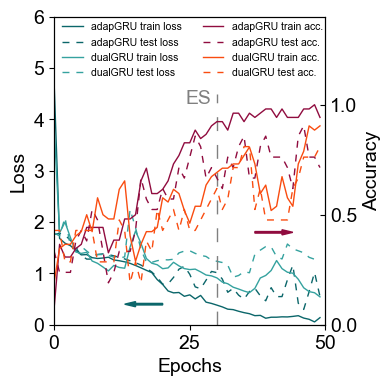

In [15]:
fig = plt.figure(figsize=[3.5, 4])

ax1 = fig.add_subplot()
ax1.plot(train_losses_ada, lw=1, c='#0B666A', label='adapGRU train loss')
ax1.plot(test_losses_ada, lw=1, ls=(0, (5, 5)), c='#0B666A', label='adapGRU test loss')
ax1.plot(train_losses, lw=1, c='#35A29F', label='dualGRU train loss')
ax1.plot(test_losses, lw=1, ls=(0, (5, 5)), c='#35A29F', label='dualGRU test loss')
ax1.arrow(20, 0.4, -5, 0, width=0.03,
          head_length=2, head_width=0.1, color='#0B666A')
ax1.set_xlim(0, 50)
ax1.set_ylim(0, 6)

ax2 = ax1.twinx()
ax2.plot(train_accuracies_ada, lw=1, c='#900C3F', label='adapGRU train acc.')
ax2.plot(test_accuracies_ada, lw=1, ls=(0, (5, 5)), c='#900C3F', label='adapGRU test acc.')
ax2.plot(train_accuracies, lw=1, c='#F94C10', label='dualGRU train acc.')
ax2.plot(test_accuracies, lw=1, ls=(0, (5, 5)), c='#F94C10', label='dualGRU test acc.')
ax1.arrow(37, 1.8, 5, 0, width=0.03,
          head_length=2, head_width=0.1, color='#900C3F')
ax2.set_ylim(0, 1.4)
ax2.set_yticks([0, 0.5, 1])

ax1.set_xticks([0, 25, 50])

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax2.set_ylabel('Accuracy')
plt.tick_params(direction='in')

ax1.vlines(30, ax1.get_xlim()[0], 4.5,
           linestyles=(0, (10, 10)), colors='gray')
ax1.text(29, 4.3, 'ES', ha='right', c='gray')
fig.legend(bbox_to_anchor=(0.12, 0.89), loc='upper left',
           fontsize=7.5, frameon=False, ncols=2)

# plt.savefig('../results/fig4/adap_vs_dual.png', dpi=600, bbox_inches='tight')

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def get_predictions_and_labels_dual(model, loader):
    all_predictions = []
    all_labels = []
    
    model.eval()
    with torch.no_grad():
        for pvs, imus, labels in loader:
            pvs = pvs.to(device)
            imus = imus.to(device)
            labels = labels.to(device)
            outputs = model(pvs, imus)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_predictions, all_labels

In [17]:
old2new_mapping = {0: 0, 1: 2, 2: 4, 3: 5, 4: 1, 5: 3}

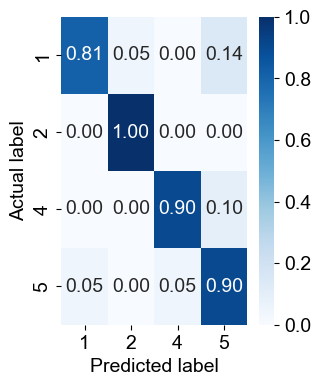

In [41]:
plt.figure(figsize=(5, 4))
torch.manual_seed(114514)

ds = torch.load('../dataset/preprocessed/yihan_dual.pt')
loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
train_ds, test_ds = random_split(ds, [train_size, test_size])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

predictions, labels = get_predictions_and_labels_dual(model_adap, loader)
predictions = [old2new_mapping[predictions] for predictions in predictions]
labels = np.array([item[0] for item in labels]).tolist()
labels = [old2new_mapping[labels] for labels in labels]

cm = confusion_matrix(labels, predictions)
indexes = [1, 2, 4, 5]
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(normalized_cm, index=indexes, columns=indexes)
sns.heatmap(df_cm, annot=True, fmt='.2f',
            vmin=0, vmax=1, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.savefig('../results/fig4/adap_confusion_mat.png', dpi=600, bbox_inches='tight')
plt.show()

In [31]:
cm

array([[17,  1,  0,  3],
       [ 0, 10,  0,  0],
       [ 0,  0, 19,  2],
       [ 1,  0,  1, 19]], dtype=int64)

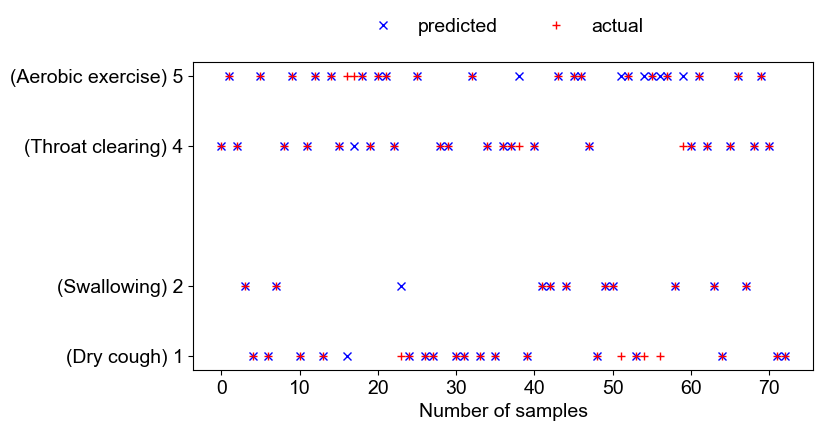

In [67]:
plt.figure(figsize=(8, 4))
plt.plot(predictions, 'bx', label='predicted')
plt.plot(labels, 'r+', label='actual')
plt.xlabel('Number of samples')
plt.yticks(indexes, labels=['(Dry cough) 1', '(Swallowing) 2', '(Throat clearing) 4', '(Aerobic exercise) 5'])
plt.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', frameon=False, ncols=2)
plt.show()